Reference: https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/

Dataset from: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

## Import libraries

In [1]:
import torch
import torchvision
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import albumentations as A
import glob as glob

from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.auto import tqdm
from albumentations.pytorch import ToTensorV2
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader

## Config

In [16]:
BATCH_SIZE = 4 # increase / decrease according to GPU memory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 4 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEPARATOR = os.path.sep

# training/validation images and XML files directory
ROOT_DIR = '.'
TRAIN_DIR = ROOT_DIR+'/data/train'
VALID_DIR = ROOT_DIR+'/data/test'
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'apple', 'banana', 'orange'
]
NUM_CLASSES = 4
# whether to visualize images after creating the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
OUT_DIR = ROOT_DIR+'/outputs'
SAVE_PLOTS_EPOCH = 1 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 1 # save model after these many epochs

# Create output folders if they don't exist
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

## Utility functions

In [3]:
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True`.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            # cv2.imshow('Transformed image', sample)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            plt.imshow(sample)
        plt.show()

## Prepare dataset
Get filename, image data and bounding boxes from folder, and separate into training and validation datasets

In [4]:
# the dataset class
class FruitDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(SEPARATOR)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
train_dataset = FruitDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = FruitDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 240
Number of validation samples: 60



### Check that the images and the bounding boxes from the dataset are loaded correctly

Number of training images: 240


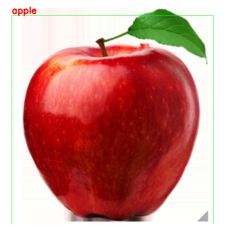

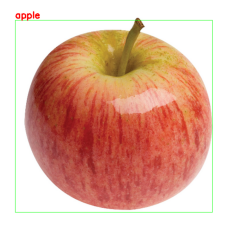

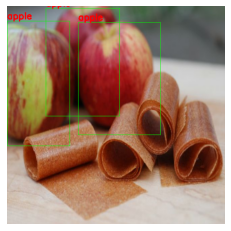

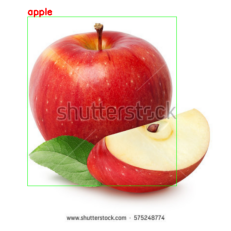

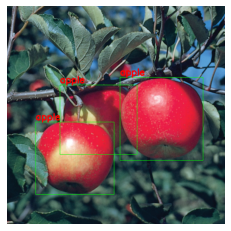

In [5]:
# sanity check of the Dataset pipeline with sample visualization
dataset = FruitDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    image = (image * 255).astype(np.uint8)
    for i in range(len(target['labels'])):
        box = target['boxes'][i]
        label = CLASSES[target['labels'][i]]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2
        )
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(np.copy(image), target)

## Neural Network (Faster RCNN)

In [6]:
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [7]:
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad() # reset the gradients as PyTorch accumulates gradients by default
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward() # backpropagation: update weights with w_{ij} = w+{ih} + dE/dw_{ij}
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

### Training the model

In [8]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till end and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(NUM_EPOCHS): # trains the model on the dataset for NUM_EPOCH times
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
  # reset the training and validation loss histories for the current epoch
  train_loss_hist.reset()
  val_loss_hist.reset()
  # create two subplots, one for each, training and validation
  figure_1, train_ax = plt.subplots()
  figure_2, valid_ax = plt.subplots()

  # start timer and carry out training and validation
  start = time.time()
  # train the dataset and then calculate the validation loss for plotting
  train_loss = train(train_loader, model)
  val_loss = validate(valid_loader, model)
  print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
  print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   

  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
  if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
      torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
      print('SAVING MODEL COMPLETE...\n')
  
  if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
      train_ax.plot(train_loss, color='blue')
      train_ax.set_xlabel('iterations')
      train_ax.set_ylabel('train loss')
      valid_ax.plot(val_loss, color='red')
      valid_ax.set_xlabel('iterations')
      valid_ax.set_ylabel('validation loss')
      figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
      figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
      print('SAVING PLOTS COMPLETE...')
  
  if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
      train_ax.plot(train_loss, color='blue')
      train_ax.set_xlabel('iterations')
      train_ax.set_ylabel('train loss')
      valid_ax.plot(val_loss, color='red')
      valid_ax.set_xlabel('iterations')
      valid_ax.set_ylabel('validation loss')
      figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
      figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
      torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
  
  plt.close('all')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]


EPOCH 1 of 4
Training


  0%|          | 0/60 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch #0 train loss: 0.529
Epoch #0 validation loss: 0.394
Took 60.995 minutes for epoch 0
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 2 of 4
Training


  0%|          | 0/60 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch #1 train loss: 0.334
Epoch #1 validation loss: 0.275
Took 59.402 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 4
Training


  0%|          | 0/60 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch #2 train loss: 0.248
Epoch #2 validation loss: 0.231
Took 67.093 minutes for epoch 2
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 4 of 4
Training


  0%|          | 0/60 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch #3 train loss: 0.217
Epoch #3 validation loss: 0.225
Took 68.524 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


## Store results for future

In [25]:
import csv

epochs = [i for i in range(1, NUM_EPOCHS+1)]

csv_header = ["Epoch", "Train loss", "Validation loss"]
csv_data = list(zip(epochs, train_loss_list, val_loss_list))
with open(f"{OUT_DIR}/results.csv", 'w') as f:
  writer = csv.writer(f)
  writer.writerow(csv_header)

  for row in csv_data:
    writer.writerow(row)

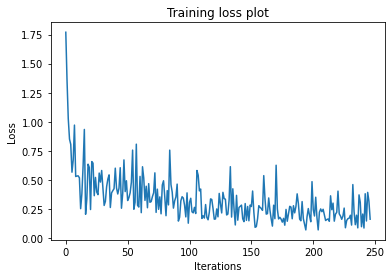

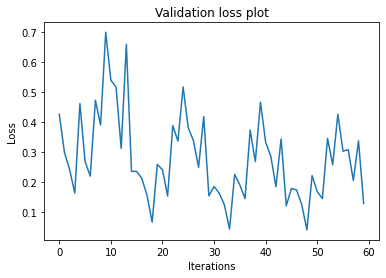

In [36]:
plt.plot(train_loss_list)

plt.title("Training loss plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.plot(val_loss_list)
plt.title("Validation loss plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()